# Задание 1


### Целью этого задания является знакомство со стандартными контейнерами и некторыми функциями из стандартных библиотек для машинного обучения.

Напишите наивный байесовский классификатор и сравните его с реализацией NaiveBayesClassifier из библиотеки nltk.

Написанный вами классификатор должен обладать следубщими свойствами:
<ul>
<li>В предложенном интерфейсе класса должны быть реализованы все методы и все поля. Для их хранения предподсчитанных данных рекомендуется использовать контейнеры Counter или defaultdict из библиотеки collections. Для предсказания категории рекомендуется использовать numpy.</li>
<li>Должна использоваться модель, предложенная в теории.</li>
<li>Точность предсказаний не менее <b>0.9</b>!</li>
<li>После реализации класса протестируйте его с помощью кроссвалидации с k=10. Рекомендуется использовать класс KFold из библиотеки sklearn.</li>
<li>Постройте постройте диаграмму размаха для классификаторов (своего и из библиотеки).</li>
</ul>

### Теория

Теория находится в файле problems1-theory.pdf

# Решение

In [4]:
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook

from collections import Counter, defaultdict
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from nltk import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from matplotlib import pyplot as plt

%pylab inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


### Прочитайте данные из файла

In [96]:
data_path = "ham-spam.csv"
data_frame = pd.read_csv(data_path)

In [97]:
data_frame.head()

,target,msg
0,ham,Subject : re : 2 . 882 s - > np np > date : su...
1,ham,Subject : s - > np + np the discussion of s - ...
2,ham,Subject : 2 . 882 s - > np np . . . for me it ...
3,ham,"Subject : gent conference "" for the listserv ""..."
4,ham,Subject : query : causatives in korean could a...


In [114]:
X, y = np.array(data_frame["msg"]), np.array(data_frame["target"])

### Реализуйте все методы в классе NaiveBayes

In [5]:
class NaiveBayes(object):
    """
    Наивный байесовский классификатор.
    Для каждого входного сообщения слово учитывается один раз при расчете итоговой вероятности.

    Parameters
    ----------
    category_priors : default | None, optional, default None
        Априорные вероятности категорий.
        Если None, то классификатор должен сам их вычислить.

    weight : float, optional, default 1
        Вес одного слова в формуле взвешенной вероятности

    supposed_prob : float, optional, default 0.5
        Предполагаемая вероятность слова в категории
    """

    def __init__(self, category_priors=None, weight=1, supposed_prob=0.5):
        self.category_priors = category_priors
        self.weight = weight
        self.supposed_prob = supposed_prob

        # Количество отдельных слов в заданной категории
        self.feature_category_counts = defaultdict(Counter)
        self.feature_category_count = defaultdict(int)

        # Количество всех документов в данной категории
        self.category_doc_counts = Counter()

        # Количество встреч слова во всех сообщениях
        self.feature_counts = Counter()
        self.feature_count = 0

    def fit(self, x_train, y_train):
        """
        Производит обучение наивного байесовского классификатора.

        Parameters
        ----------
        x_train : list of str
            содержит список (сообщений). слова в сообщении должны быть разделены пробелом.

        y_train : list of str
            содержит список меток (названий категорий) для сообщений из x_train

        Returns
        -------
        self : object
            Returns self
        """
        # Подсчитываем количество категорий, документов и слов в каждой категории
        # и количество встреч слова во всех сообщениях
        self.category_doc_counts.update(y_train)
        
        x_train = np.array(list(
            map(lambda message: np.unique(message.split()), x_train)))
        
        for (document, cat) in zip(x_train, y_train):
            self.feature_category_counts[cat].update(document)
            self.feature_category_count[cat] = \
                sum(list(self.feature_category_counts[cat].values()))
            self.feature_counts.update(document)
        self.feature_count = sum(list(self.feature_counts.values()))
        
        # Если априорные вероятности категорий не заданы, то надо аппроксимировать их
        if self.category_priors is None:
            y_train = np.array(y_train)
            
            self.category_priors = defaultdict(float)
            for cat in self.get_categories():
                self.category_priors[cat] = sum(y_train == cat) / len(y_train)
            
        return self

    def predict(self, text):
        """
        Предсказывает метки категорий для text.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которая будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.

        Returns
        -------
        categories : list of str
            Возвращает названия категорий для text.
        """
        texts = self.tokenize(text)
        
        categories = []
        for text in texts:
            categories.append(
                self.get_categories()[np.argmax(self.get_probs(text))])

        return categories

    def score(self, text, labels):
        """
        Возвращает точность предсказаний на text для правильных категорий labels.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которая будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.
        labels : list of str
            Список категорий для каждого токена из text.

        Returns
        -------
        acc : list of float
            Массив с точностями предсказаний точность предсказания.
        """
        texts = self.tokenize(text)
        
        categories = np.array(self.predict(text))
        labels = np.array(labels)
        acc = sum(categories == labels) / len(labels)
            
        return acc

    def get_probs(self, text):
        """
        Считает вероятности принадлежности текста (text) к каждой из категорий

        Parameters
        ----------
        text : list of str | str
            Входной текст описывается строкой, которая будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.

        Returns
        -------
        probs : list of float
            Возвращает вероятности probs всех категорий для текста text
            в порядке их следования в self.category_doc_counts.
        """
        # Токенизируем текст, если это необходимо
        text = self.tokenize(text)[0]
            
        probs = []
        for cat in self.get_categories():
            probs.append(self.get_category_prob(cat, text))

        return probs

    def get_category_prob(self, cat, text):
        """
        Считает логарифм вероятности принадлежности сообщения text к категории cat.

        Parameters
        ----------
        cat : str
            Название категории.

        text : list of str
            Список из слов.

        Returns
        -------
        log_prob : float
            Возвращает логарифм вероятности категории cat для текста text.
        """
        log_prob = np.log(self.category_priors[cat]) \
            + sum(list(map(lambda word: np.log(self.get_weighted_feature_prob(cat, word)), text)))

        return log_prob

    def get_weighted_feature_prob(self, cat, feature):
        """
        Вычисляет взвешенную вероятность P(Слово|Категория).

        Parameters
        ----------
        
        cat : str
            Название категории.

        feature : str
            Слово из текста.

        Returns
        -------
        prob : float
            Возвращает взвешенную вероятность слова feature при условии категории cat.
        """
        if feature in self.feature_counts:
            prob = (self.weight \
                    * (self.feature_counts[feature] / self.feature_count \
                    + (self.feature_category_counts[cat][feature] \
                       / self.feature_category_count[cat]))) \
                / (self.weight + 1)
        else:
            return 0.5
        
        return prob

    def get_categories(self):
        """
        Возвращает список названий всех категорий.
        Returns
        -------
        cat_list : list of str
        """
        cat_list = list(self.category_doc_counts.keys())
        return cat_list
    
    def tokenize(self, text):
        """
        Токенизирует тексты, если это необходимо

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которая будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.

        Returns
        -------
        texts : list of list of str | list of srt
            Возвращает токенизированные тексты.
        """
        if isinstance(text, str):
            texts = [ text.split() ]
        elif isinstance(text[0], str):
            if np.any(list(map(lambda element: " " in element, text))):
                texts = list(map(lambda document: document.split(), text))
            else:
                texts = [ text ]
        else:
            texts = text
            
        return texts

### Сравните вашу реализацию и реализацию из библиотеки nltk

Для использования классификатора из библиотеки не забудьте предподготовить данные. Для подсчета точности этого классификатора можете использовать accuracy_score из метрик sklearn. Для подсчета точности предсказаний вашего классификатора используйте функцию score, которую вы опишете.

In [111]:
# Предобработка данных для классификатора nltk, если требуется
class NLTKData:
    def __init__(self, vocabulary, text):
        self.vocabulary = vocabulary
        self.text = text
        self.words = set(text)
    
    def items(self):
        items = []
        for word in self.vocabulary:
            items.append((word, word in self.words))
        return items
    
    def keys(self):
        return list(self.vocabulary)
    
    def copy(self):
        return NLTKData(self.vocabulary, self.text)
        
class NLTKCreator:
    def __init__(self, texts):
        self.vocabulary = set()
        for text in texts:
            self.vocabulary.update(text)
    
    def create(self, text):
        return NLTKData(self.vocabulary, text)

In [115]:
X_tokens = list(map(lambda doc: doc.lower().split(), X))

In [116]:
nltk_creator = NLTKCreator(X_tokens)
X_nltk = np.array(list(map(nltk_creator.create, X_tokens)))

In [142]:
# Используйте процедуру KFold для проверки качества классификаторов
kf = KFold(len(y), n_folds=10, shuffle=True, random_state=24)

nltk_accuracy = []
for k, (train_index, test_index) in tqdm_notebook(enumerate(kf)):
    nb = NaiveBayesClassifier.train(zip(X_nltk[train_index], y[train_index]))
    
    cat = list(map(nb.classify, X_nltk[test_index]))
    nltk_accuracy.append(accuracy_score(cat, y[test_index]))
    print("(NLTK) [Fold {}]: {}".format(k, nltk_accuracy[-1]))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

(NLTK) [Fold 0]: 0.9517241379310345
(NLTK) [Fold 1]: 0.9517241379310345
(NLTK) [Fold 2]: 0.9655172413793104
(NLTK) [Fold 3]: 0.9653979238754326
(NLTK) [Fold 4]: 0.9584775086505191
(NLTK) [Fold 5]: 0.9619377162629758
(NLTK) [Fold 6]: 0.9480968858131488
(NLTK) [Fold 7]: 0.916955017301038
(NLTK) [Fold 8]: 0.9619377162629758
(NLTK) [Fold 9]: 0.9653979238754326



In [153]:
# Используйте процедуру KFold для проверки качества классификаторов
kf = KFold(len(y), n_folds=10, shuffle=True, random_state=24)

naive_accuracy = []
for k, (train_index, test_index) in tqdm_notebook(enumerate(kf)):    
    nb = NaiveBayes()
    nb.fit(X[train_index], y[train_index])
    naive_accuracy.append(nb.score(X[test_index], y[test_index]))
    print("(NaiveBayes) [Fold {}]: {}".format(k, naive_accuracy[-1]))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

(NaiveBayes) [Fold 0]: 0.9448275862068966
(NaiveBayes) [Fold 1]: 0.9344827586206896
(NaiveBayes) [Fold 2]: 0.9517241379310345
(NaiveBayes) [Fold 3]: 0.972318339100346
(NaiveBayes) [Fold 4]: 0.9411764705882353
(NaiveBayes) [Fold 5]: 0.9411764705882353
(NaiveBayes) [Fold 6]: 0.9584775086505191
(NaiveBayes) [Fold 7]: 0.9757785467128027
(NaiveBayes) [Fold 8]: 0.972318339100346
(NaiveBayes) [Fold 9]: 0.9515570934256056



### Постройте графики размаха для двух классификаторов на одной фигуре.

Рекомендуется использовать встроенные функции построения графиков в pandas.

In [5]:
nltk_accuracy = [0.9517241379310345, 0.9517241379310345, 0.9655172413793104,
                 0.9653979238754326, 0.9584775086505191, 0.9619377162629758,
                 0.9480968858131488, 0.916955017301038, 0.9619377162629758, 
                 0.9653979238754326]

naive_accuracy = [0.9448275862068966, 0.9344827586206896, 0.9517241379310345,
                  0.972318339100346, 0.9411764705882353, 0.9411764705882353, 
                  0.9584775086505191, 0.9757785467128027, 0.972318339100346, 
                  0.9515570934256056]

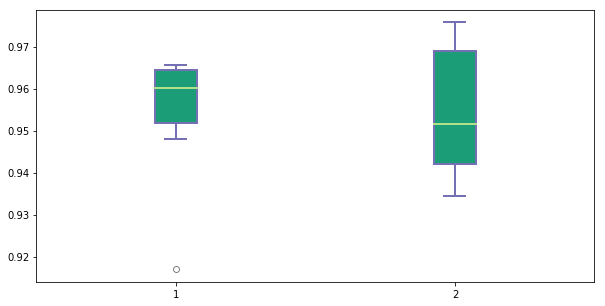

In [14]:
plt.figure(figsize=(10, 5))

bp = plt.boxplot([nltk_accuracy, naive_accuracy], patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

plt.show()